In [19]:
!pip install investpy

In [20]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from keras_preprocessing import sequence
from keras.models import Sequential

In [21]:
import investpy
pfe = investpy.get_stock_historical_data(stock = 'PFE' , country = 'United States' , from_date = '01/01/2005' , to_date = '01/12/2020')
pfe.head()

,Open,High,Low,Close,Volume,Currency
Date,,,,,,
2005-01-03,25.89,25.93,25.07,25.07,46085200,USD
2005-01-04,25.04,25.22,24.68,25.07,38701800,USD
2005-01-05,25.10,25.14,24.79,24.90,27448800,USD
2005-01-06,25.03,25.14,24.91,24.92,20256000,USD
2005-01-07,25.16,25.22,24.90,24.93,22322600,USD


In [22]:
pfe.to_csv('pfe_data.csv')

In [23]:
df = pd.read_csv('pfe_data.csv' , usecols=['Date','Close'] ,parse_dates=True , index_col='Date')

In [24]:
df.head()

,Close
Date,
2005-01-03,25.07
2005-01-04,25.07
2005-01-05,24.90
2005-01-06,24.92
2005-01-07,24.93


##Plot The Close Prices

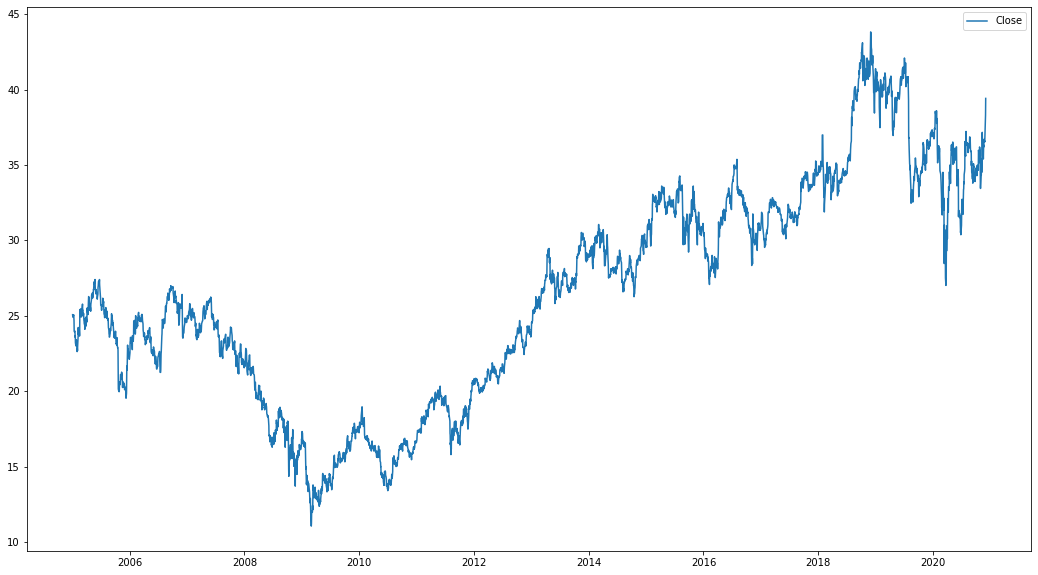

In [25]:
plt.figure(figsize=(18,10))
plt.plot(df['Close'])
plt.legend(['Close'])
plt.show();

##Scale the data and normalize

In [26]:
from sklearn.preprocessing import MinMaxScaler

In [27]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)
print(scaled_data)

[[0.42783033]
 [0.42783033]
 [0.42264266]
 ...
 [0.79890143]
 [0.83185841]
 [0.86542569]]


##Make the train and test data

In [28]:
train_length = int(len(scaled_data) * 0.7)
test_length = len(scaled_data) - train_length
train_data = scaled_data[0:train_length, :]
test_data = scaled_data[train_length:len(scaled_data), :]

In [29]:
test_data

array([[0.53127861],
       [0.54775709],
       [0.53738175],
       ...,
       [0.79890143],
       [0.83185841],
       [0.86542569]])

## Make the label with numpy array

In [30]:
def create_dataset(dataset, timestep):
  data_x , data_y = [] , []
  for i in range (len(dataset) - timestep - 1):
    data_x.append(dataset[i:(i+timestep) , 0])
    data_y.append(dataset[i+timestep, 0])
  return np.array(data_x) ,np.array(data_y)

In [31]:
timestep = 1
train_x , train_y = create_dataset(train_data , timestep)
test_x , test_y = create_dataset(test_data ,timestep)
print(train_x) #the train_y will be the same 

[[0.42783033]
 [0.42783033]
 [0.42264266]
 ...
 [0.51998779]
 [0.51754654]
 [0.51602075]]


In [32]:
train_x.shape

(2802, 1)

#Reshape the train to fit the model 

In [33]:
train_x = np.reshape(train_x ,(train_x.shape[0] , 1, train_x.shape[1]))
test_x = np.reshape(test_x ,(test_x.shape[0] ,1, test_x.shape[1]))

print(train_x)

[[[0.42783033]]

 [[0.42783033]]

 [[0.42264266]]

 ...

 [[0.51998779]]

 [[0.51754654]]

 [[0.51602075]]]


#Build the model

In [34]:
import tensorflow as tf

In [35]:
from keras.layers import LSTM , Dense
from keras.callbacks import EarlyStopping

I will Build a Normal Regression Model as model_1

In [68]:
#Set random Seed
tf.random.set_seed(42)

#Create The model
model_1 = tf.keras.Sequential([
  tf.keras.layers.LSTM(100, return_sequences=True, input_shape=(1,1)),
  tf.keras.layers.LSTM(10,return_sequences=False),
  tf.keras.layers.Dense(1)
])

#compile the model
model_1.compile(loss=tf.keras.losses.mae,
                          optimizer=tf.keras.optimizers.Adam(), # Adam works but SGD doesn't 
                          metrics=['mae'])

#Fit the model
history= model_1.fit(train_x,train_y,epochs=50)

Epoch 1/50
88/88 [==============================] - 6s 6ms/step - loss: 0.1805 - mae: 0.1805
Epoch 2/50
88/88 [==============================] - 1s 6ms/step - loss: 0.0446 - mae: 0.0446
Epoch 3/50
88/88 [==============================] - 1s 6ms/step - loss: 0.0125 - mae: 0.0125
Epoch 4/50
88/88 [==============================] - 1s 6ms/step - loss: 0.0107 - mae: 0.0107
Epoch 5/50
88/88 [==============================] - 1s 7ms/step - loss: 0.0093 - mae: 0.0093
Epoch 6/50
88/88 [==============================] - 1s 6ms/step - loss: 0.0084 - mae: 0.0084
Epoch 7/50
88/88 [==============================] - 1s 6ms/step - loss: 0.0073 - mae: 0.0073
Epoch 8/50
88/88 [==============================] - 1s 6ms/step - loss: 0.0071 - mae: 0.0071
Epoch 9/50
88/88 [==============================] - 1s 6ms/step - loss: 0.0069 - mae: 0.0069
Epoch 10/50
88/88 [==============================] - 1s 7ms/step - loss: 0.0071 - mae: 0.0071
Epoch 11/50
88/88 [==============================] - 1s 6ms/step - lo

In [69]:
model_1.evaluate(test_x,test_y)

38/38 [==============================] - 1s 3ms/step - loss: 0.0131 - mae: 0.0131


[0.013072148896753788, 0.013072148896753788]

Text(0, 0.5, 'Epochs')

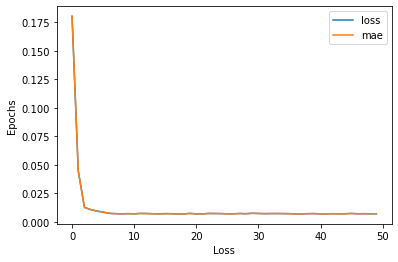

In [70]:
pd.DataFrame(history.history).plot()
plt.xlabel('Loss')
plt.ylabel('Epochs')

In [71]:
train_pred = model_1.predict(train_x)
test_pred = model_1.predict(test_x)

print(train_pred)

[[0.42933357]
 [0.42933357]
 [0.42412424]
 ...
 [0.5213355 ]
 [0.5189153 ]
 [0.5174022 ]]


In [72]:
train_pred = scaler.inverse_transform(train_pred)
train_y = scaler.inverse_transform([train_y])
test_pred = scaler.inverse_transform(test_pred)
test_y = scaler.inverse_transform([test_y])

print(train_pred)

[[25.11926 ]
 [25.11926 ]
 [24.948551]
 ...
 [28.134165]
 [28.054855]
 [28.00527 ]]


In [73]:
train_pred_plot = np.empty_like(scaled_data)
train_pred_plot[:,:] =np.nan
train_pred_plot[1:len(train_pred) +1 , :] = train_pred

In [74]:
test_pred_plot = np.empty_like(scaled_data)
test_pred_plot[:,:] = np.nan
test_pred_plot [len(train_pred)+2 +1:len(scaled_data)-1 , :] = test_pred

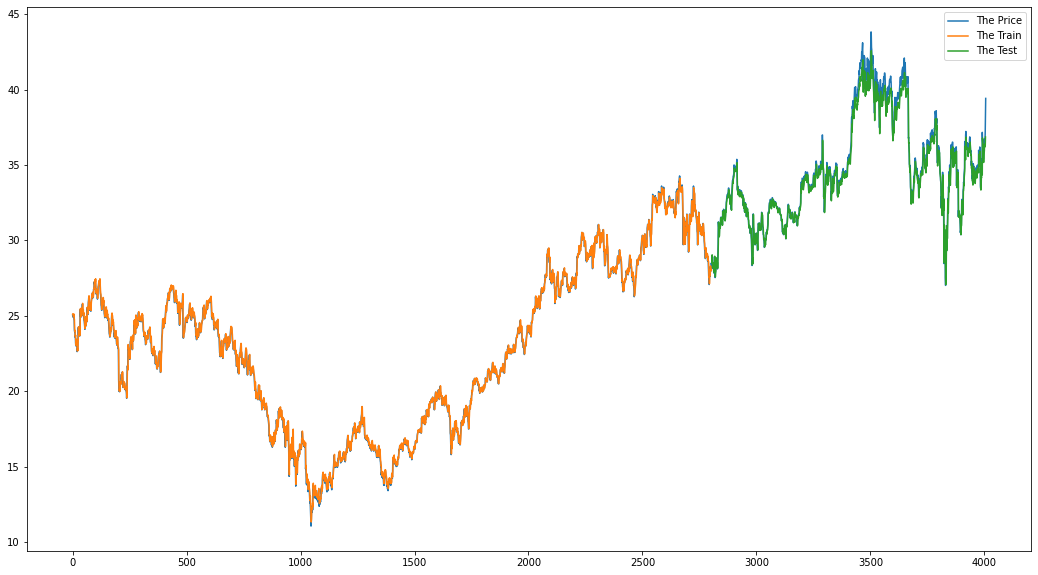

In [75]:
plt.figure(figsize=(18,10))
plt.plot(scaler.inverse_transform(scaled_data))
plt.plot(train_pred_plot)
plt.plot(test_pred_plot)
plt.legend(['The Price' , 'The Train' , 'The Test'])
plt.show()

# Train With LSTM

In [ ]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(1,1)))
model.add(LSTM(50 ,return_sequences=False))
model.add(Dense(25))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='mean_squared_error' , optimizer = 'adam' , metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 50)             10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 25)                1275      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 26        
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


In [ ]:
early_stop = EarlyStopping(monitor='loss', patience=1)

In [ ]:
model.fit(train_x , train_y , epochs=200 , verbose=1,callbacks=[early_stop])
score = model.evaluate(train_x, train_y ,verbose=0)
print(f'Keras Model loss = {score[0]*100}')
print(f'Keras Model Accuracy = {score[1]*100}')

Epoch 1/200
88/88 [==============================] - 4s 4ms/step - loss: 0.0339 - accuracy: 3.2962e-05
Epoch 2/200
88/88 [==============================] - 0s 4ms/step - loss: 0.0102 - accuracy: 2.0270e-05
Epoch 3/200
88/88 [==============================] - 0s 4ms/step - loss: 3.6363e-04 - accuracy: 2.2999e-04
Epoch 4/200
88/88 [==============================] - 0s 4ms/step - loss: 3.3553e-04 - accuracy: 5.1754e-04
Epoch 5/200
88/88 [==============================] - 0s 4ms/step - loss: 2.7456e-04 - accuracy: 7.8748e-04
Epoch 6/200
88/88 [==============================] - 0s 4ms/step - loss: 2.5405e-04 - accuracy: 4.5497e-04
Epoch 7/200
88/88 [==============================] - 0s 4ms/step - loss: 2.3334e-04 - accuracy: 9.9139e-05
Epoch 8/200
88/88 [==============================] - 0s 4ms/step - loss: 2.1107e-04 - accuracy: 1.6160e-04
Epoch 9/200
88/88 [==============================] - 0s 4ms/step - loss: 1.8175e-04 - accuracy: 1.9413e-04
Epoch 10/200
88/88 [=========================

In [ ]:
train_pred = model.predict(train_x)
test_pred = model.predict(test_x)

print(train_pred)

[[0.42807415]
 [0.42807415]
 [0.42242497]
 ...
 [0.5239819 ]
 [0.5216902 ]
 [0.5199665 ]]


In [ ]:
train_pred = scaler.inverse_transform(train_pred)
train_y = scaler.inverse_transform([train_y])
test_pred = scaler.inverse_transform(test_pred)
test_y = scaler.inverse_transform([test_y])

print(train_pred)

[[26.458525]
 [26.458525]
 [26.263231]
 ...
 [29.774055]
 [29.69483 ]
 [29.63524 ]]


In [ ]:
train_pred_plot = np.empty_like(scaled_data)
train_pred_plot[:,:] =np.nan
train_pred_plot[1:len(train_pred) +1 , :] = train_pred

In [ ]:
test_pred_plot = np.empty_like(scaled_data)
test_pred_plot[:,:] = np.nan
test_pred_plot [len(train_pred)+2 +1:len(scaled_data)-1 , :] = test_pred

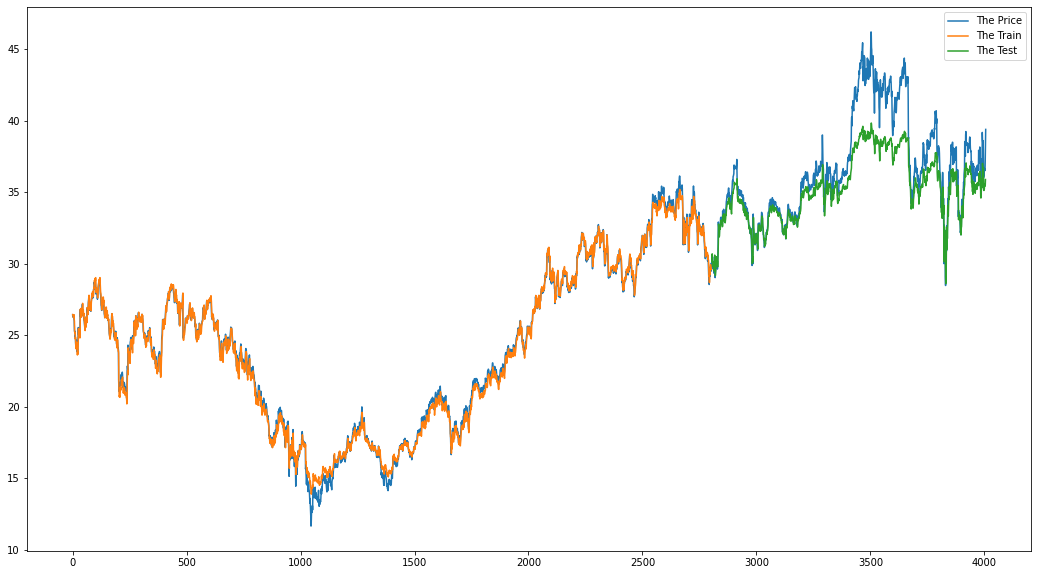

In [ ]:
plt.figure(figsize=(18,10))
plt.plot(scaler.inverse_transform(scaled_data))
plt.plot(train_pred_plot)
plt.plot(test_pred_plot)
plt.legend(['The Price' , 'The Train' , 'The Test'])
plt.show()

In [ ]:
model.save('pfe_model.h5')